In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

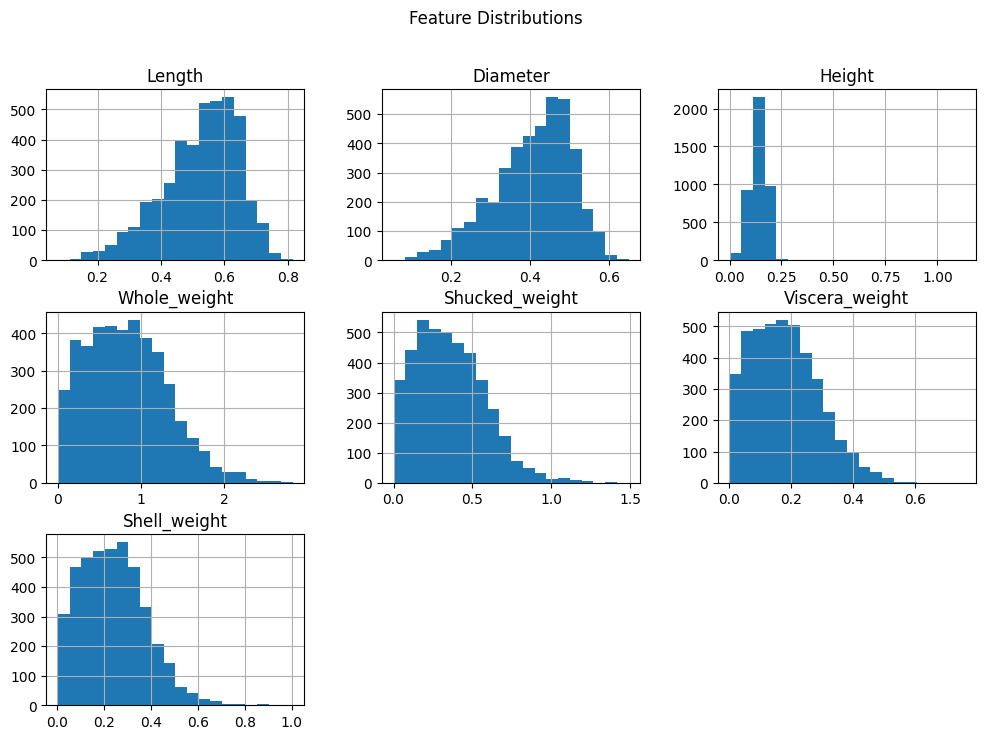

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

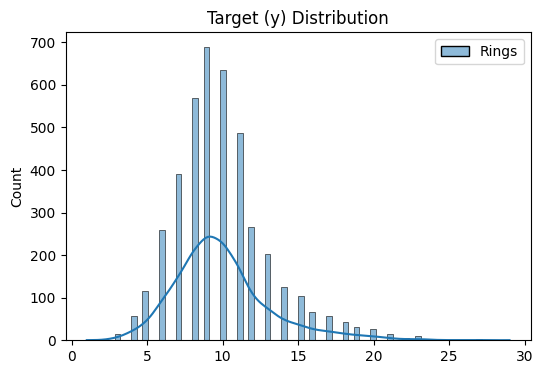

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

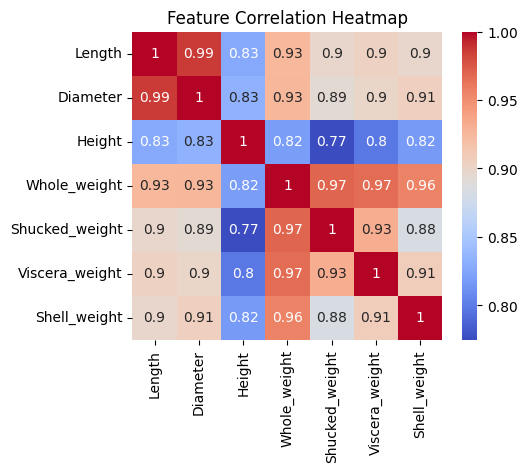

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=8, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=8)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.053078                 1.016445             1.112767   
1                  1.050577                 1.011761             1.060839   
2                  1.088445                 1.105851             1.217678   
3                  1.022099                 1.074224             1.100206   
4                  1.037967                 1.042098             1.152130   
5                  1.078755                 1.036068             1.041893   
6                  1.121267                 1.079093             1.130001   
7                  1.065867                 1.064944             1.137371   
mean               1.064757                 1.053811             1.119111   
std                0.031228                 0.032742             0.054790   

      DefaultBART_Rhat_RMSE  
0                  1.305407  
1                  1.271418  
2                  1.256027

In [10]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

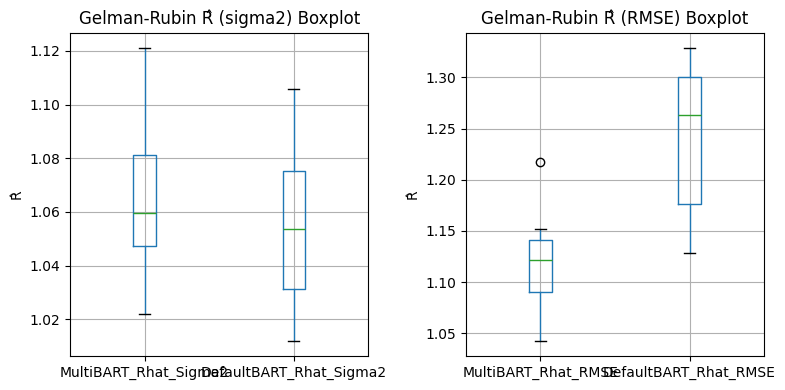

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-11-24 14:58:15,076:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 14:58:15,528:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 14:58:16,512:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      4.832882  4.796755  4.904282  4.791655  5.722874
1      4.787301  4.792363  4.814522  4.574730  5.348410
2      5.264923  5.331955  5.341948  5.399027  5.810473
3      4.442280  4.532149  4.514895  4.645710  5.385919
4      4.361990  4.364493  4.469933  4.558238  5.046336
5      5.054937  5.103660  5.142656  5.052298  5.874977
6      5.178331  5.071604  4.937390  4.946810  5.660102
7      5.279011  5.302287  5.287504  5.139162  5.571136
mean   4.900207  4.911908  4.926641  4.888454  5.552528
std    0.357463  0.351027  0.325284  0.299893  0.276999



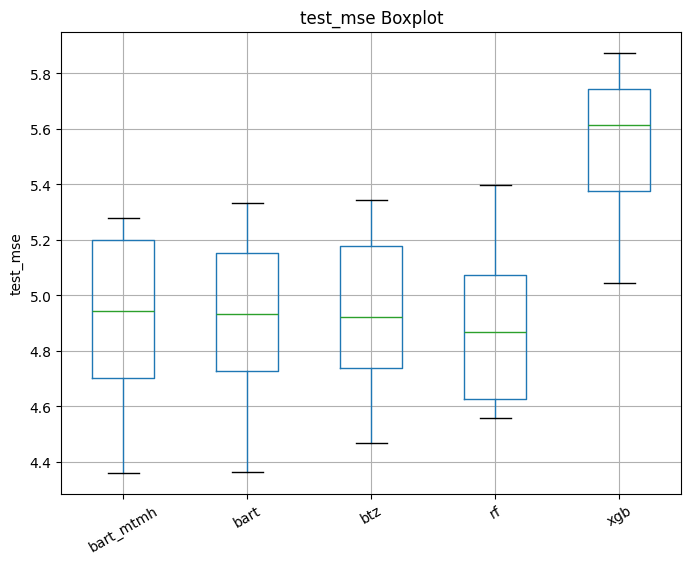

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      3.837447  3.937398  3.919932  0.679427  0.542755
1      3.876407  4.052922  3.998078  0.683244  0.606606
2      3.665093  3.810047  3.762385  0.639765  0.543232
3      3.889049  4.031716  3.964029  0.677036  0.545936
4      3.968086  4.061852  4.066866  0.681703  0.621954
5      3.729431  3.944893  3.831448  0.647193  0.533894
6      3.693320  3.903738  3.876115  0.680122  0.566025
7      3.669369  3.790310  3.772048  0.656752  0.540149
mean   3.791025  3.941610  3.898863  0.668155  0.562569
std    0.116130  0.104629  0.108582  0.017467  0.033479



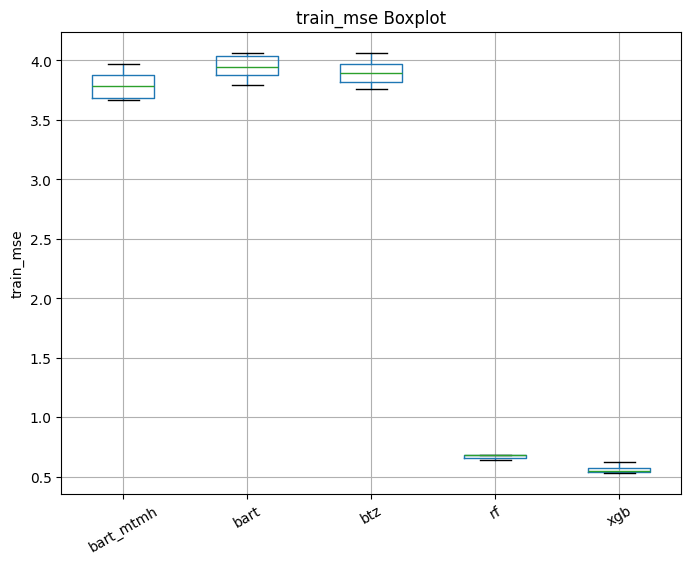

pi_length:
      bart_mtmh      bart       btz
0      8.223865  8.186687  8.329155
1      8.177477  8.221240  8.294741
2      8.077288  8.032412  8.184007
3      8.277462  8.229784  8.284444
4      8.349271  8.289094  8.426198
5      8.048349  8.130565  8.264561
6      7.990083  8.150477  8.283384
7      8.037340  8.077923  8.245120
mean   8.147642  8.164773  8.288951
std    0.128734  0.084336  0.069762



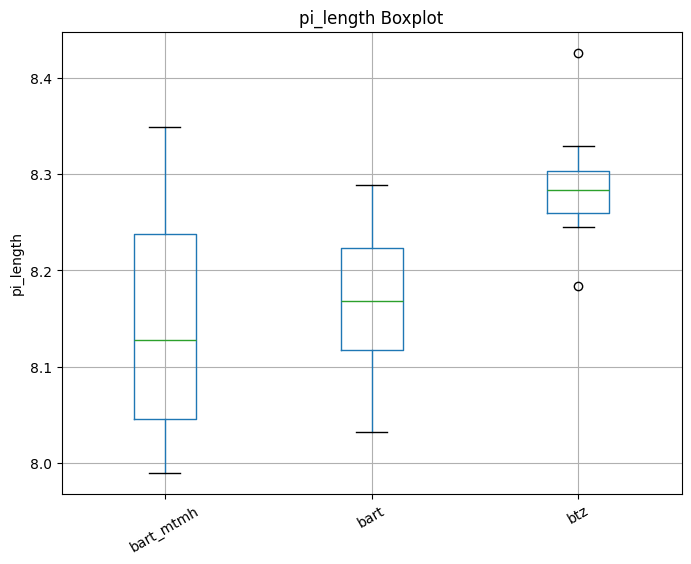

coverage:
      bart_mtmh      bart       btz
0      0.934928  0.938756  0.942584
1      0.932057  0.933971  0.931100
2      0.933971  0.928230  0.923445
3      0.939713  0.939713  0.940670
4      0.944498  0.944498  0.942584
5      0.930144  0.922488  0.933014
6      0.915789  0.922488  0.923445
7      0.917703  0.919617  0.924402
mean   0.931100  0.931220  0.932656
std    0.009945  0.009326  0.008466



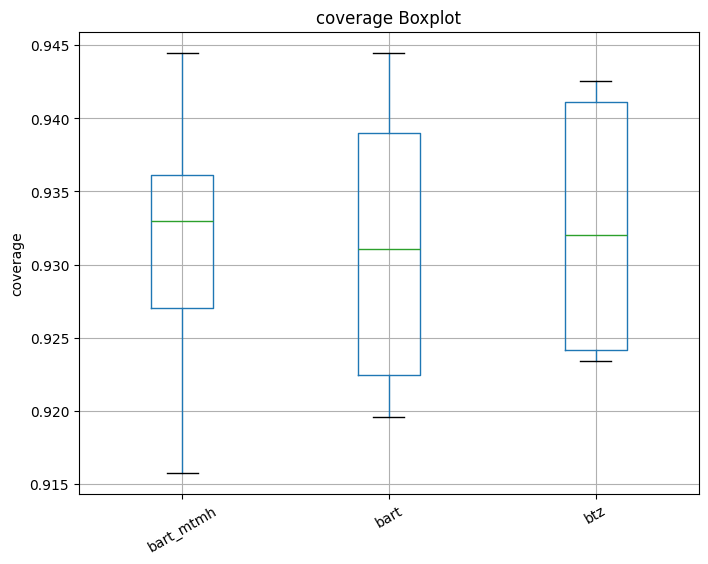

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     230.471967  32.849709  80.712157  3.180776  0.126649
1     229.966654  33.041267  79.508970  3.395901  0.253855
2     232.991217  33.343582  83.131863  1.783166  0.126481
3     231.908641  33.243306  82.210679  2.173278  0.125292
4     231.149307  33.075989  82.188930  2.198653  0.116949
5     231.807826  33.301542  82.520530  1.967619  0.125920
6     231.737215  33.481643  82.513537  1.769301  0.123169
7     231.472670  32.979924  81.708165  2.342008  0.130524
mean  231.438187  33.164620  81.811854  2.351338  0.141105
std     0.929125   0.211736   1.168736  0.614470  0.045721



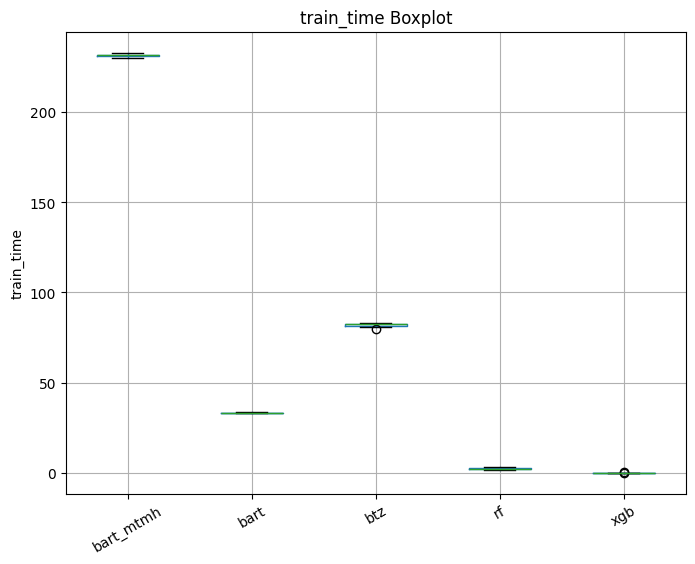

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=8, n_skip=1000, n_post=1000, n_trees=100, n_jobs=8)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [10]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real1_Abalone_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 20, 50],
    n_runs=8, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=-1
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real1_Abalone_tries.csv", index=False)

In [11]:
import pandas as pd
df = pd.read_csv("results/real1_Abalone_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.045522   1.353533  4.918872  0.931220   60.943765
1            5     1.086035   1.172533  4.919753  0.929785  145.418210
2           10     1.064757   1.119111  4.872505  0.930742  234.896689
3           20     1.070179   1.136475  4.892691  0.927751  420.320200
4           50     1.059241   1.121384  4.906400  0.931818  944.653211
